1. 1개의 포인트가 59정도인 경우 제거?
2. 65, 60, 55 3개의 저혈압 포인트
그룹을 다양하게

전처리를 좀더 빡빡하게
튀는 값이 혹시라도 저혈압 구간을 부풀리지 않는지

In [1]:
import os
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import dask.dataframe as dd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import xgboost as xgb
from xgboost import dask as dxgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask.array as da
from sklearn import svm, datasets
import dask_ml.model_selection as dcv

In [2]:
datapath= '/home/wlsdud022/data/6d007e8d-0f03-45ed-bd30-f7c6de906ac0/project_data/project_data/EMR/jy/Post-induction/Input_preprocessing/'
df_pih = pd.read_csv(os.path.join(datapath,'PIH_input_new.csv'))

del df_pih['OP_CODE']
del df_pih['OPID']

print(df_pih.keys())

Index(['ASA', 'Sex', 'Age', 'HT', 'WT', 'BMI', 'rdw', 'mpv', 'pdw', 'e_alc',
       'e_neutro', 'na', 'alp', 'tc', 'egfr_ce', 'egfr_md', 'icteric_index',
       'wbc', 'rbc', 'mcv', 'mch', 'mchc', 'e_lympho', 'e_baso', 'ig', 'plt',
       'hb', 'hct', 'pt_sec', 'pt_inr', 'aptt', 'k', 'cl', 'ca', 'glu', 'cr',
       'bun', 'ast', 'alt', 'tp', 'ua', 'tco2', 'bilirubin', 'crp', 'alb',
       'mono', 'e_anc', 'EMOP', 'induc_propofol', 'induc_midazolam',
       'induc_pentotal', 'Desflurane', 'Sevoflurane', 'Propofol', 'WARD_SBP',
       'WARD_DBP', 'WARD_MBP', 'Pre-induction_SBP', 'Pre-induction_DBP',
       'Pre-induction_MBP', 'Hypotension', 'Hypotension_Area', 'PIH_Gr',
       'PIH_Gr1', 'PIH_Gr2', 'PIH_Gr3', 'Hypotension_Time(minute)', 'MBP_Max',
       'MBP_Mean', 'MBP_Min', 'area_time'],
      dtype='object')


In [3]:
var_list = ['Sex','Age','HT','WT','BMI','rdw','mpv','pdw','na','alp','tc','egfr_ce','egfr_md','icteric_index','wbc','rbc','mcv','mch','mchc','plt','hb','hct','pt_sec','pt_inr','aptt','k','cl','ca','glu','cr','bun','ast','alt','tp','ua','tco2','bilirubin','crp','alb','EMOP','induc_propofol','induc_midazolam','induc_pentotal','Desflurane','Sevoflurane','Propofol','WARD_SBP','WARD_DBP','WARD_MBP','Pre-induction_SBP','Pre-induction_DBP','Pre-induction_MBP']
demo_list = ['Sex','Age','HT','WT','BMI']
preoplab_list = ['rdw','mpv','pdw','na','alp','tc','egfr_ce','egfr_md','icteric_index','wbc','rbc','mcv','mch','mchc','plt','hb','hct','pt_sec','pt_inr','aptt','k','cl','ca','glu','cr','bun','ast','alt','tp','ua','tco2','bilirubin','crp','alb']
anesthetics_list = ['induc_propofol','induc_midazolam','induc_pentotal','Desflurane','Sevoflurane','Propofol']
bp_list = ['WARD_SBP','WARD_DBP','WARD_MBP','Pre-induction_SBP','Pre-induction_DBP','Pre-induction_MBP']
pat_bp_list = ['WT','HT','Age','Sex','ASA','WARD_SBP','WARD_DBP','WARD_MBP','Pre-induction_SBP','Pre-induction_DBP','Pre-induction_MBP']

y_pih = df_pih['Hypotension']
y_pihm = df_pih['PIH_Gr']
y_pih1 = df_pih['PIH_Gr1']
y_pih2 = df_pih['PIH_Gr2']
y_pih3 = df_pih['PIH_Gr3']

In [5]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_pih, y_pih, test_size=0.20, shuffle=True)

scaler = StandardScaler()
feature = X_train_full.columns
scaler.fit(X_train_full)
X_train_t_scaled = pd.DataFrame(scaler.transform(X_train_full))
X_test_t_scaled = pd.DataFrame(scaler.transform(X_test_full))
 
def clf3():
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier() 
    xg = XGBClassifier(tree_method='gpu_hist', gpu_id=1)
  
    return rfc, gb, xg

xg_parameters ={
    'max_depth' : [6,7,8], 
    'n_estimators': [50, 100, 200], 
    'learning_rate':[0.1], 
    'gamma': [0.5, 1, 2], 
    'alpha' : [0, 1, 5],
    'subsample' : [0.5, 1.0],
    'colsample_bytree' : [0.5, 1.0],
    'lambda' : [0, 1, 5],
}

rfc, gb, xg = clf3()

cluster = LocalCUDACluster()
client = Client(cluster)

xg.set_params(**xg_parameters)

/home/wlsdud022/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33787 instead
  warnings.warn(
2023-08-31 13:55:13,546 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:55:13,546 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-31 13:55:13,563 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:55:13,563 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-31 13:55:13,633 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:55:13,633 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


XGBClassifier(alpha=[0, 1, 5], base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=[0.5, 1.0], early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=[0.5, 1, 2], gpu_id=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=[0, 1, 5], learning_rate=[0.1], max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=[6, 7, 8], max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=[50, 100, 200], n_jobs=None, num_parallel_tree=None, ...)

### DASK, XGBOOST, GRIDSEARCHCV

In [4]:
cluster = LocalCUDACluster()
client = Client(cluster)

X_train_t_scaled_dask = dd.from_pandas(X_train_t_scaled, npartitions=4)
y_train_dask = dd.from_pandas(y_train_full, npartitions=4)

dtrain = dxgb.DaskDMatrix(client, X_train_t_scaled_dask, y_train_dask)
output = xgboost.dask.train(client,
                            {'verbosity': 2,
                             'tree_method': 'gpu_hist',
                             'objective': 'binary:logistic'},
                            dtrain,
                            num_boost_round=100,
                            evals=[(dtrain, 'train')])

grid_search = GridSearchCV ( estimator = xg,
                            param_grid = xg_parameters,
                            scoring = 'recall',
                            cv = 10,
                            vervose=2
                            )

grid_search.fit(X_train_t_scaled_dask.compute(), y_train_dask.compute())
best_rfc = grid_search.best_estimator_
best_rfc

2023-08-31 13:54:59,846 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:54:59,846 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-31 13:54:59,992 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:54:59,992 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-31 13:54:59,993 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-31 13:54:59,993 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


NameError: name 'X_train_t_scaled' is not defined

### DASK, XGBOOST, Bayesian Optimization

## USE DASK GPU

In [6]:
X_train_t_scaled_dask = dd.from_pandas(X_train_t_scaled, npartitions=4)
y_train_dask = dd.from_pandas(y_train_full, npartitions=4)

dtrain = dxgb.DaskDMatrix(client, X_train_t_scaled_dask, y_train_dask)
output = xgboost.dask.train(client,
                            {'verbosity': 2,
                             'tree_method': 'gpu_hist',
                             'objective': 'binary:logistic'},
                            dtrain,
                            num_boost_round=100,
                            evals=[(dtrain, 'train')])

clf = dcv.GridSearchCV(estimator= xg, 
                       param_grid = xg_parameters, 
                       scoring = 'recall', 
                       cv= 10, 
                       scheduler=client
                      )

clf.fit(X_train_t_scaled_dask.compute(), y_train_dask.compute())
best_rfc = clf.best_estimator_
best_rfc

INFO:distributed.worker:Run out-of-band function '_start_tracker'
[10:18:11] task [xgboost.dask-0]:tcp://127.0.0.1:32931 got new rank 0
[10:18:11] task [xgboost.dask-1]:tcp://127.0.0.1:44731 got new rank 1
[10:18:11] task [xgboost.dask-2]:tcp://127.0.0.1:45919 got new rank 2


[0]	train-logloss:0.63066
[1]	train-logloss:0.59865
[2]	train-logloss:0.58084
[3]	train-logloss:0.57135
[4]	train-logloss:0.56580
[5]	train-logloss:0.56138
[6]	train-logloss:0.55938
[7]	train-logloss:0.55764
[8]	train-logloss:0.55634
[9]	train-logloss:0.55486
[10]	train-logloss:0.55251
[11]	train-logloss:0.55134
[12]	train-logloss:0.54977
[13]	train-logloss:0.54829
[14]	train-logloss:0.54668
[15]	train-logloss:0.54527
[16]	train-logloss:0.54330
[17]	train-logloss:0.54268
[18]	train-logloss:0.54105
[19]	train-logloss:0.53942
[20]	train-logloss:0.53816
[21]	train-logloss:0.53660
[22]	train-logloss:0.53544
[23]	train-logloss:0.53383
[24]	train-logloss:0.53196
[25]	train-logloss:0.53055
[26]	train-logloss:0.52918
[27]	train-logloss:0.52811
[28]	train-logloss:0.52727
[29]	train-logloss:0.52526
[30]	train-logloss:0.52385
[31]	train-logloss:0.52198
[32]	train-logloss:0.52129
[33]	train-logloss:0.51933
[34]	train-logloss:0.51801
[35]	train-logloss:0.51605
[36]	train-logloss:0.51456
[37]	train-

NameError: name 'grid_search' is not defined

In [14]:
best_rfc = clf.best_estimator_
best_rfc

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [27]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_pih, y_pih, test_size=0.20, shuffle=True, random_state=99)

del X_train_full['Hypotension']
del X_train_full['Hypotension_Time(minute)']
del X_train_full['Hypotension_Area']
del X_train_full['PIH_Gr']
del X_train_full['PIH_Gr1']
del X_train_full['PIH_Gr2']
del X_train_full['PIH_Gr3']
del X_train_full['area_time']
del X_train_full['MBP_Max']
del X_train_full['MBP_Mean']
del X_train_full['MBP_Min']

del X_test_full['Hypotension']
del X_test_full['Hypotension_Time(minute)']
del X_test_full['Hypotension_Area']
del X_test_full['PIH_Gr']
del X_test_full['PIH_Gr1']
del X_test_full['PIH_Gr2']
del X_test_full['PIH_Gr3']
del X_test_full['area_time']
del X_test_full['MBP_Max']
del X_test_full['MBP_Mean']
del X_test_full['MBP_Min']

scaler = StandardScaler()
feature = X_train_full.columns
scaler.fit(X_train_full)
X_train_t_scaled = pd.DataFrame(scaler.transform(X_train_full))
X_test_t_scaled = pd.DataFrame(scaler.transform(X_test_full))

len(X_train_t_scaled)
len(X_test_t_scaled)
len(df_pih)
y_train_full

29513    0
15657    1
69786    1
41597    1
39624    1
        ..
57042    0
36008    0
46265    0
23587    0
29313    0
Name: Hypotension, Length: 57178, dtype: int64

In [31]:
pih_t_xgb = xgb.XGBClassifier(
    reg_lambda=1,
    alpha=1,
    gamma=0,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    n_estimators=200, 
    tree_method='gpu_hist', gpu_id=1)

pih_t_xgb.fit(X=X_train_t_scaled, y=y_train_full, verbose=2)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

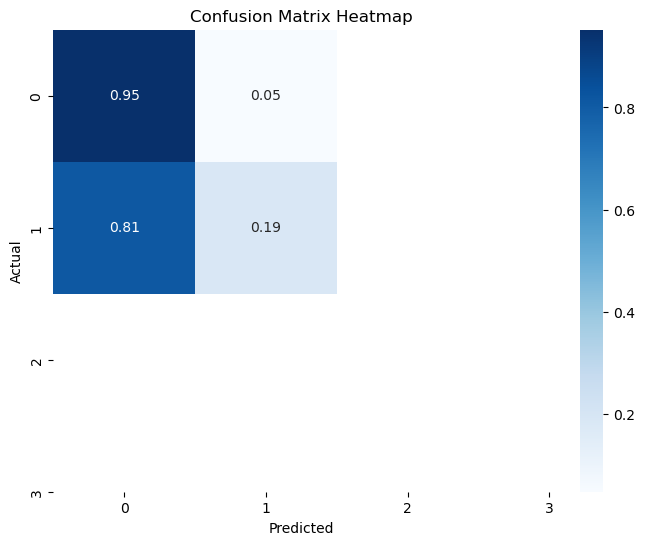

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_pred_t = best_rfc.predict(X_test_t_scaled)
y_test_pred_t = pih_t_xgb.predict(X_test_t_scaled)
conf_mat = confusion_matrix(y_test_full, y_test_pred_t)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# heatmap으로 표현
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [2]:
3629*0.19

689.51